# ANALYSE EXPLORATOIRE DES DONNÉES

Les donnees utilisees pour ce travail sont celles [d'Olist](https://olist.com/pt-br/), une solution de vente sur differentes Marketplace. Olist propose a ses clients une interface pour publier leurs produits sur Amazon, CasaBahia, submarino, madeiramadeira, etc.

_N.B : Les donnees utilisees sont accessibles sur Kaggle, [ici](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)_


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import squarify

import cluster_viz as cv810
import acp_graphs as acp810

In [28]:
CSVFOLDER = './data_og/'
df_customers = pd.read_csv(CSVFOLDER + 'olist_customers_dataset.csv')
df_trads = pd.read_csv(CSVFOLDER + 'product_category_name_translation.csv')
df_products = pd.read_csv(CSVFOLDER + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(CSVFOLDER + 'olist_sellers_dataset.csv')
df_orderitems = pd.read_csv(CSVFOLDER + 'olist_order_items_dataset.csv')
df_orderpayments = pd.read_csv(CSVFOLDER + 'olist_order_payments_dataset.csv')
df_orders = pd.read_csv(CSVFOLDER + 'olist_orders_dataset.csv')
df_reviews = pd.read_csv(CSVFOLDER + 'olist_order_reviews_dataset.csv')
df_geolocations = pd.read_csv(CSVFOLDER + 'olist_geolocation_dataset.csv')

# Instanciation de notre df de travail
df_wip = pd.DataFrame()

In [29]:
DATEREF = dt.datetime(2019, 1, 1, 0, 0, 0)

# 1. Etude des tables

On va etudier les tables une par une pour mieux comprendre les relations entre nos donnees.

## 1.1. Commandes

In [30]:
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [31]:
df_orders.shape

(99441, 8)

In [32]:
df_orders[df_orders['order_id'].duplicated()].shape[0]

0

In [33]:
df_orders[df_orders['customer_id'].duplicated()].shape[0]

0

Au début, cela peut laisser penser que nous n'avons que des clients uniques. Mais c'est juste lié à la table et au nommage des features.

In [34]:
np.round((96478-99441)/99441*100, 2)

-2.98

In [35]:
df_orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Dans un premier temps, on ne va travailler qu'avec les status "delivered". Cependant, si nous souhaitions approfondir une etude de satisfaction ou identifier des commandes problematiques, il faudra etudier les differents status

__Perspectives d'amelioration :__
- On pourrait essayer de voir si les differents status ont une influence sur la categorisation des clients.
- On pourrait créer une feature comptant le nombre de jours entre la commande et la livraison, car ceci affecte certainement les avis.

Beaucoup de dates distinctes, relatives au processus d'achat-livraison. Pour notre RFM, on va se contenter de conserver seulement la data d'achat.

On cree un dataframe de travail, df_wip :

In [36]:
df_wip = df_orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]

## 1.2. Clients

In [37]:
df_customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [38]:
df_customers.shape[0]

99441

Autant de lignes de clients que de lignes de commandes.

In [39]:
df_customers[df_customers['customer_id'].duplicated()].shape[0]

0

In [40]:
df_customers[df_customers['customer_unique_id'].duplicated()].shape[0]

3345

In [41]:
client_reguliers = df_customers[df_customers['customer_unique_id'].duplicated()].shape[0]
clients_totaux = df_customers['customer_unique_id'].nunique()
part_clients_reguliers = (client_reguliers/clients_totaux)*100
print(f"On a {np.round(part_clients_reguliers, 2)}% de client reguliers sur l'ensemble du dataset")

On a 3.48% de client reguliers sur l'ensemble du dataset


Étonnament, la colonne contenant "unique" dans son nom est celle qui ne l'est pas. xD

C'est l'identifiant client à considérer pour identifier les clients qui ont acheté régulierement. On va l'ajouter à notre WIP (Work In Progress), puis on supprimera l'autre à l'issue de toutes nos transformations.

In [42]:
df_customers['customer_state'].value_counts(normalize=True).head(7)

customer_state
SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
SC    0.036574
BA    0.033990
Name: proportion, dtype: float64

On va regrouper les états représentant moins de 5% pour reduire la cardinalité de notre colonne.

In [43]:
lst_provclient_moins5pourcent = df_customers['customer_state'].value_counts(normalize=True)[df_customers['customer_state'].value_counts(normalize=True) < 0.05].index
df_customers.loc[df_customers['customer_state'].isin(lst_provclient_moins5pourcent), 'customer_state'] = "Autres"
del(lst_provclient_moins5pourcent)

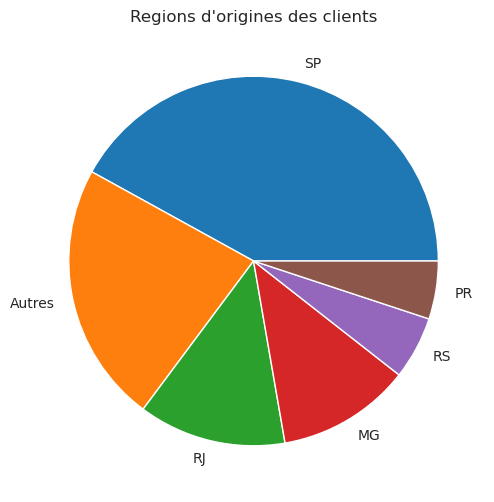

In [44]:
plt.figure(figsize=(8, 6))
plt.pie(x=df_customers['customer_state'].value_counts(), labels=df_customers['customer_state'].value_counts().index)
plt.title("Regions d'origines des clients")
plt.show()

Nos commandes proviennent pour la plupart de la region de Sao Paolo.

In [45]:
df_wip = df_wip.merge(df_customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
print("WIP, Nombre de feature disposant de valeurs nulles : ", df_wip.isna().sum()[df_wip.isna().sum()!=0].shape[0])
print("WIP, shape : ", df_wip.shape)

WIP, Nombre de feature disposant de valeurs nulles :  0
WIP, shape :  (99441, 6)


In [46]:
df_wip.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres


## 1.3. Produits

In [47]:
df_products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


Un identifiant produit, une categorie de produit et des dimensions

In [48]:
df_products.shape

(32951, 9)

In [49]:
df_products['product_category_name'].nunique()

73

In [50]:
df_trads.shape

(71, 2)

Hélas, il n'y a pas autant de catégories traduites que de catégories de produits. Il va falloir imputer xD

In [51]:
df_products = df_products.merge(df_trads, on='product_category_name', how='left')
df_products.shape

(32951, 10)

In [52]:
df_products.isna().sum()[df_products.isna().sum()!=0]

product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

610 produits n'ont pas de catégorie associée, c'est moins de 2%.

In [53]:
df_tmp = df_products[~df_products['product_category_name'].isna()]
df_tmp.isna().sum()[df_tmp.isna().sum()!=0]

product_weight_g                  1
product_length_cm                 1
product_height_cm                 1
product_width_cm                  1
product_category_name_english    13
dtype: int64

In [54]:
df_tmp[df_tmp['product_category_name_english'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer,59.0,621.0,4.0,2839.0,19.0,16.0,18.0,NaN
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0,NaN
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer,60.0,1532.0,3.0,650.0,16.0,22.0,20.0,NaN
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0,NaN
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0,NaN
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,NaN
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer,60.0,840.0,6.0,800.0,18.0,22.0,22.0,NaN
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,NaN


In [55]:
df_products.loc[df_products['product_category_name'] == 'pc_gamer', 'product_category_name_english'] == 'pc_gamer'
df_products.loc[df_products['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_english'] == 'preparation_alimentaire'
del(df_tmp)

In [57]:
df_products['product_category_name'].value_counts()[df_products['product_category_name'].value_counts() < 300].nunique()

43

43/73 catégories de produits sont représentées à moins de 1%. Le business repose sur quelques catégories de produits.

## 1.4. Revendeurs

In [58]:
df_sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [59]:
df_sellers.shape

(3095, 4)

In [60]:
print("Nombre de valeurs distincts (Etats) : ", df_sellers['seller_state'].nunique())
print("Nombre represente a moins de 3% : ", len(df_sellers['seller_state'].value_counts()[df_sellers['seller_state'].value_counts() < 30])) # <3%

Nombre de valeurs distincts (Etats) :  23
Nombre represente a moins de 3% :  15


In [61]:
lst_provseller_moins5pourcent = df_sellers['seller_state'].value_counts(normalize=True)[df_sellers['seller_state'].value_counts(normalize=True) < 0.05].index
df_sellers.loc[df_sellers['seller_state'].isin(lst_provseller_moins5pourcent), 'seller_state'] = "Autres"
del(lst_provseller_moins5pourcent)

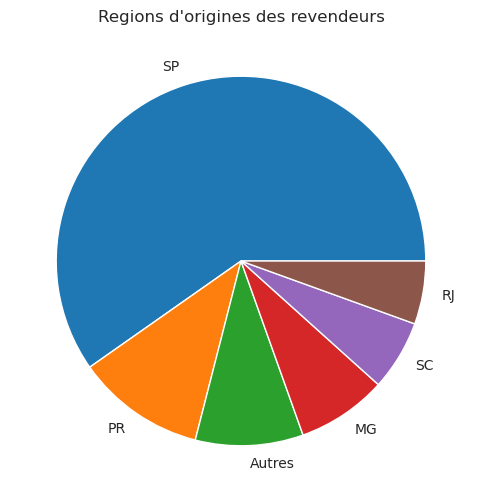

In [62]:
plt.figure(figsize=(8, 6))
plt.pie(x=df_sellers['seller_state'].value_counts(), labels=df_sellers['seller_state'].value_counts().index)
plt.title("Regions d'origines des revendeurs")
plt.show()

La plupart des revendeurs proviennent de Sao Paolo.

## 1.5. Produits commandés

In [63]:
df_orderitems.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [64]:
print("Nombre de revendeurs differents : ", df_orderitems['seller_id'].nunique())

Nombre de revendeurs differents :  3095


In [65]:
df_orderitems['seller_id'].value_counts(normalize=True).head(5)

seller_id
6560211a19b47992c3666cc44a7e94c0    0.018047
4a3ca9315b744ce9f8e9374361493884    0.017639
1f50f920176fa81dab994f9023523100    0.017142
cc419e0650a3c5ba77189a1882b7556a    0.015757
da8622b14eb17ae2831f4ac5b9dab84a    0.013768
Name: proportion, dtype: float64

In [66]:
df_orderitems.shape

(112650, 7)

In [67]:
df_orderitems[df_orderitems['order_id'].duplicated()].head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10


In [68]:
df_orderitems[df_orderitems['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


Une commande peut concerner plusieurs produits. Chaque produit dispose d'un prix et de frais de ports associés. 

Si une commande contient trois fois le même produit, alors cette table contient trois lignes associées à ladite commande, ou seul diffère le order_item_id.

In [69]:
# Associonsla categorie aux differents items
df_tmp = df_products[['product_id', 'product_category_name_english']]
df_orderitems = df_orderitems.merge(df_tmp, on="product_id", how='left')
df_orderitems.isna().sum()[df_orderitems.isna().sum()!=0]

product_category_name_english    1627
dtype: int64

Une partie des produits vendus n'a pas de catégorie associée. Mais c'est une part assez maigre, et pour la résolution du problème demandé, il n'est même pas sûr que ce soit nécessaire.

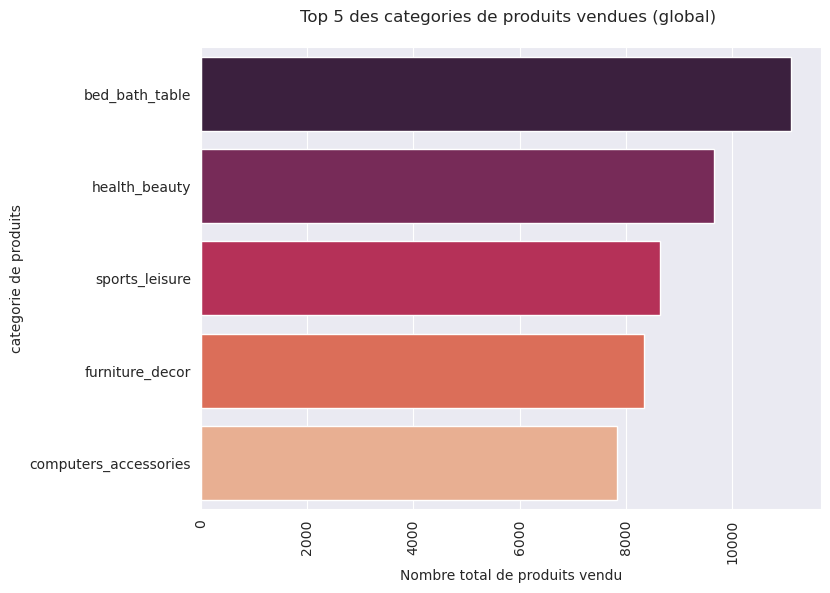

In [73]:
top5_itemcat = df_orderitems['product_category_name_english'].value_counts().head(5).reset_index()
plt.figure(figsize=(8, 6))
sns.color_palette("rocket", as_cmap=True)
sns.barplot(x=top5_itemcat['count'], y=top5_itemcat['product_category_name_english'], orient='h', palette="rocket")
# sns.despine(left=True, bottom=True) # Vire les axes
plt.plot
# Setting the label for x-axis
plt.xlabel("Nombre total de produits vendu")
# Setting the label for y-axis
plt.ylabel("categorie de produits")
# Setting the title for the graph
plt.title("Top 5 des categories de produits vendues (global) \n")
plt.xticks(rotation=90)
plt.show()

#### Nombre d'items associés a la commande

In [74]:
# nb_item_par_commande = order_id
nb_item_par_commande = df_orderitems.groupby('order_id')['product_id'].count().reset_index()
plus_de_1_item = nb_item_par_commande[nb_item_par_commande['product_id'] != 1]

In [75]:
nb_item_par_commande.rename(columns={'product_id' : 'nb_items'}, inplace=True)

In [76]:
nb_item_par_commande[nb_item_par_commande['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,nb_items
31,00143d0f86d6fbd9f9b38ab440ac16f5,3


In [77]:
df_wip = df_wip.merge(nb_item_par_commande, on='order_id', how='left')
df_wip.isna().sum()[df_wip.isna().sum()!=0]

nb_items    775
dtype: int64

#### Associer les catégories de produits

Pas sur qu'on les utilise, car il faudra les retravailler pour pouvoir les One-Hot Encoder.

Par ailleurs, il y a pas mal de valeurs manquantes.

In [78]:
nb_item_diff_par_commande = df_orderitems.groupby('order_id')['product_id'].nunique().reset_index()
nb_item_diff_par_commande.rename(columns={'product_id' : 'nbitemdiff'}, inplace=True)
nb_item_diff_par_commande.head(3)

,order_id,nbitemdiff
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1


In [79]:
commandes_1_type = nb_item_diff_par_commande[nb_item_diff_par_commande['nbitemdiff'] == 1]
commandes_n_types = nb_item_diff_par_commande[nb_item_diff_par_commande['nbitemdiff'] > 1]['order_id'].tolist()

In [80]:
commandes_1_type = commandes_1_type.merge(df_orderitems[['order_id', 'product_category_name_english']], on='order_id', how='left')
commandes_1_type.isna().sum()

order_id                            0
nbitemdiff                          0
product_category_name_english    1539
dtype: int64

In [81]:
commandes_1_type['order_id'].nunique()

95430

In [82]:
commandes_1_type = commandes_1_type[~commandes_1_type.isna()]
commandes_1_type = commandes_1_type[~commandes_1_type['order_id'].duplicated()]

In [83]:
df_wip.loc[df_wip['order_id'].isin(commandes_n_types), 'cat_produit'] = 'Multiples'
df_wip = df_wip.merge(commandes_1_type[['order_id', 'product_category_name_english']], on='order_id', how='left')
print("Shape df_wip : ", df_wip.shape)
print("NB NaN df_wip : ", df_wip.isna().sum().sum())

Shape df_wip :  (99441, 9)
NB NaN df_wip :  102394


In [84]:
df_wip.isna().sum()[df_wip.isna().sum()!=0]

nb_items                           775
cat_produit                      96205
product_category_name_english     5414
dtype: int64

In [85]:
df_wip.loc[df_wip['cat_produit'].isna(), 'cat_produit'] = df_wip['product_category_name_english']
df_wip.drop(columns=['product_category_name_english'], inplace=True)
df_wip.isna().sum()[df_wip.isna().sum()!=0]

nb_items        775
cat_produit    2178
dtype: int64

## 1.6. Paiements associés aux commandes

In [86]:
df_orderpayments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [87]:
df_orderpayments.shape

(103886, 5)

In [88]:
df_orderpayments[df_orderpayments['order_id'].duplicated()].head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
1456,683bf306149bb869980b68d48a1bd6ab,1,credit_card,1,8.58
2324,e6a66a8350bb88497954d37688ab123e,2,voucher,1,10.51
2393,8e5148bee82a7e42c5f9ba76161dc51a,1,credit_card,1,0.67


In [89]:
df_orderpayments[df_orderpayments['order_id'] == '683bf306149bb869980b68d48a1bd6ab']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
385,683bf306149bb869980b68d48a1bd6ab,2,voucher,1,30.00
1456,683bf306149bb869980b68d48a1bd6ab,1,credit_card,1,8.58


Le paiement d'une commande peut se faire de plusieurs manières : Une partie avec un bon d'achat + une partie en CB, par exemple. D'où la possibilité d'avoir plusieurs lignes par commande.

In [90]:
df_orderpayments['order_id'].nunique()

99440

Toutes nos commandes sont cependant présentes dans ce dataset, sauf une. A identifier.

Montant associé à chaque moyen de paiement :

In [91]:
df_orderpayments.groupby('payment_type')['payment_value'].sum()

payment_type
boleto          2869361.27
credit_card    12542084.19
debit_card       217989.79
not_defined           0.00
voucher          379436.87
Name: payment_value, dtype: float64

boleto : methode de paiement propre au Brezil (cf. [ici](https://www.rapyd.net/blog/what-is-boleto/))

C'est la deuxième méthode de paiement la plus populaire sur Olist, après les Credit Cards. 

On va créer une colonne spéciale pour les "vouchers" (bons de reduction), cela permettra d'identifier les clients qui en utilisent.

In [92]:
df_orderpayments['reducs'] = 0
df_orderpayments.loc[df_orderpayments['payment_type'] == 'voucher', 'reducs'] = 1
df_orderpayments['reducs'].value_counts()

reducs
0    98111
1     5775
Name: count, dtype: int64

In [93]:
nb_reducs = df_orderpayments.groupby('order_id')['reducs'].sum().reset_index()
df_wip = df_wip.merge(nb_reducs, on='order_id', how='left')
print("WIP, Nombre de feature disposant de valeurs nulles : ", df_wip.isna().sum()[df_wip.isna().sum()!=0].shape[0])
print("WIP, shape : ", df_wip.shape)

WIP, Nombre de feature disposant de valeurs nulles :  3
WIP, shape :  (99441, 9)


In [94]:
df_wip.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0


In [95]:
df_orderpayments[df_orderpayments['order_id'] =='e481f51cbdc54678b7cc49136f2d6af7']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,reducs
10770,e481f51cbdc54678b7cc49136f2d6af7,1,credit_card,1,18.12,0
44246,e481f51cbdc54678b7cc49136f2d6af7,3,voucher,1,2.00,1
91130,e481f51cbdc54678b7cc49136f2d6af7,2,voucher,1,18.59,1


In [96]:
# Somme le montant des reductions par commande
montant_reducs = df_orderpayments[df_orderpayments['reducs'] == 1].groupby('order_id')['payment_value'].sum().reset_index()
df_wip = df_wip.merge(montant_reducs, on='order_id', how='left')
df_wip.rename(columns={"payment_value" : "montant_reducs"}, inplace=True)
df_wip.loc[df_wip['montant_reducs'].isna(), 'montant_reducs'] = 0
print("WIP, Nombre de feature disposant de valeurs nulles : ", df_wip.isna().sum()[df_wip.isna().sum()!=0].shape[0])
print("WIP, shape : ", df_wip.shape)

WIP, Nombre de feature disposant de valeurs nulles :  3
WIP, shape :  (99441, 10)


On va ajouter les montants de nos commandes à notre dataset de travail.

In [97]:
montants_commandes = df_orderpayments.groupby('order_id')['payment_value'].sum().reset_index()

In [98]:
df_wip = df_wip.merge(montants_commandes, on='order_id', how='left')
print("WIP, Nombre de feature disposant de valeurs nulles : ", df_wip.isna().sum()[df_wip.isna().sum()!=0].shape[0])
print("WIP, shape : ", df_wip.shape)

WIP, Nombre de feature disposant de valeurs nulles :  4
WIP, shape :  (99441, 11)


In [99]:
df_wip.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0,20.59,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0,0.00,141.46


En definissant le montant total de la commande via la table order_payments, on a une valeur nulle. On va la compléter en utilisant la table de commande des produits étudiée precedemment.

In [100]:
df_wip[df_wip['payment_value'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,SP,3.0,health_beauty,NaN,0.0,NaN


In [101]:
montant_comx = df_orderitems[df_orderitems['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']['price'].sum() + df_orderitems[df_orderitems['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']['freight_value'].sum()
df_wip.loc[df_wip['payment_value'].isna(), 'payment_value'] = montant_comx

In [102]:
df_wip.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0,20.59,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0,0.00,141.46


## 1.7. Revues et Avis

In [103]:
df_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [104]:
print("Reviews shape : ", df_reviews.shape)
print("Commandes shape : ", df_orders.shape)

Reviews shape :  (99224, 7)
Commandes shape :  (99441, 8)


On a un peu moins de reviews que de commandes

In [105]:
df_reviews['order_id'].nunique()

98673

Certaines commandes disposent de plusieurs avis, on va simplement garder le dernier en date.

__Perspectives d'amelioration :__
- Eventuellement faire la moyenne des avis pour une commande pourrait aussi avoir du sens.

In [106]:
# On met la date au format date
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'],yearfirst=True)
df_reviews.dtypes

review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp            object
dtype: object

In [107]:
df_reviews = df_reviews.sort_values(by=['review_creation_date'], ascending=False)

In [108]:
df_reviews = df_reviews[~df_reviews['order_id'].duplicated(keep='first')]
df_reviews.shape

(98673, 7)

In [109]:
df_tmp = df_reviews.drop(columns=['review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'])
df_tmp.head(2)

,order_id,review_score
10764,bd2c2c3a4d59e68fb14a526745572883,4
55456,529a65336debb1c3e3327d7d67dc733d,5


In [110]:
df_wip = df_wip.merge(df_tmp, on='order_id', how='left')
del(df_tmp)
df_wip.isna().sum()[df_wip.isna().sum()!=0]

nb_items         775
cat_produit     2178
reducs             1
review_score     768
dtype: int64

On va imputer les quelques reviews manquantes à la mediane des reviews totale

In [111]:
df_wip.loc[df_wip['review_score'].isna(), 'review_score'] = df_wip['review_score'].median()
df_wip.isna().sum()[df_wip.isna().sum()!=0]

nb_items        775
cat_produit    2178
reducs            1
dtype: int64

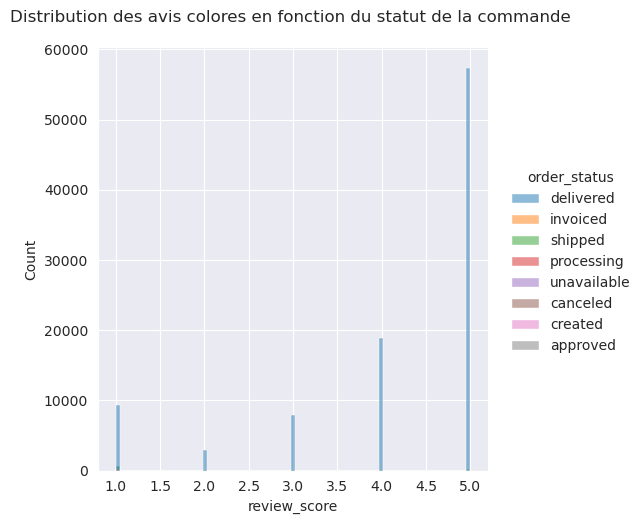

In [112]:
sns.displot(data = df_wip, x = 'review_score', hue='order_status')
plt.title("Distribution des avis colores en fonction du statut de la commande \n")
plt.show()

La quantite de commandes delivered ecrase les autres statuts qui pourraient necessiter une analyse plus approfondie. On peut constater que la grande majorite des personnes sont tres satisfaites.

In [113]:
df_wip['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [114]:
df_wip['order_status'].value_counts(normalize=True)

order_status
delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: proportion, dtype: float64

## 1.8. Divers : Geolocalisation

In [115]:
df_geolocations.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [116]:
df_geolocations.shape

(1000163, 5)

Cette table ne nous intéressera pas pour cette étude.

# 2. Creation Dataframe d'analyse

In [117]:
df_wip['order_purchase_timestamp'] = pd.to_datetime(df_wip['order_purchase_timestamp'],yearfirst=True)
df_wip.head(2)


,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0,20.59,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0,0.00,141.46,4.0


__Perspectives d'amelioration :__
- Pour l'instant on ne va travailler qu'avec les commandes livrées.

In [118]:
df_wip = df_wip[df_wip['order_status'] == 'delivered']
# Ca ne sert a rien de garder la colonne qui n'a plus qu'une valeur
df_wip.drop(columns=['order_status'], inplace=True)
df_wip.isna().sum()[df_wip.isna().sum()!=0]

cat_produit    1344
reducs            1
dtype: int64

In [119]:
df_wip.loc[df_wip['reducs'].isna(), 'reducs'] = df_wip['reducs'].median()
df_wip.loc[df_wip['cat_produit'].isna(), 'cat_produit'] = 'Inconnue'

In [120]:
df_wip.shape

(96478, 11)

In [121]:
df_wip['customer_unique_id'].nunique()

93358

In [122]:
df_wip['customer_unique_id'].duplicated().sum()

3120

In [123]:
df_wip.to_csv('./data_travail/df_merged.csv', index=False)

# 3. Analyses de regularite

On va travailler sur une version plus légère du dataframe :

In [124]:
df = df_wip[['order_id', 'order_purchase_timestamp', 'customer_unique_id', 'customer_state', 'payment_value', 'review_score']]

In [135]:
def creer_tableau_synthese(df_ini) :
    # Montant total depense par client
    synthese_df = df_ini.groupby(by='customer_unique_id')['payment_value'].sum().reset_index()
    # Frequence d'achat (ou plutot nombre de commandes)
    nb_commandes = df_ini['customer_unique_id'].value_counts().reset_index()
    synthese_df = synthese_df.merge(nb_commandes, on='customer_unique_id', how='left')
    # Date de derner achat (Recence)
    df_ini = df_ini.sort_values(by='order_purchase_timestamp', ascending=False)
    tmp = df_ini[~df_ini['customer_unique_id'].duplicated(keep='first')]
    tmp = tmp[['order_purchase_timestamp', 'customer_unique_id']]
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Bonus : Avis moyen
    tmp = df_ini.groupby('customer_unique_id')['review_score'].mean().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Rennommage des colonnes pour lisibilite
    synthese_df.rename(columns={'customer_unique_id' : 'client', 'payment_value' : 'depense', 'order_purchase_timestamp' : 'datedernierachat', 'review_score' : 'avis_moyen'}, inplace=True)
    return synthese_df

## 3.1. Tableau de synthèse global

Pour rappel, dans ce tableau de synthese, on ne travaille que sur la base des commandes qui ont ete livrees.

In [136]:
df.head(2)

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,141.46,4.0


In [137]:
df.shape

(96478, 6)

In [138]:
print("Nombre de clients total : ", df['customer_unique_id'].nunique())

Nombre de clients total :  93358


In [139]:
print("Nombre de clients reguliers : ", df['customer_unique_id'].value_counts()[df['customer_unique_id'].value_counts() > 1].shape[0])

Nombre de clients reguliers :  2801


In [140]:
panier_moyen_global = df['payment_value'].mean()
print("Panier moyen global : ", panier_moyen_global)

Panier moyen global :  159.85618721366527


In [141]:
synthese_df = creer_tableau_synthese(df_ini=df)
synthese_df.head(2)

,client,depense,count,datedernierachat,avis_moyen
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,2018-05-10 10:56:27,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,2018-05-07 11:11:27,4.0


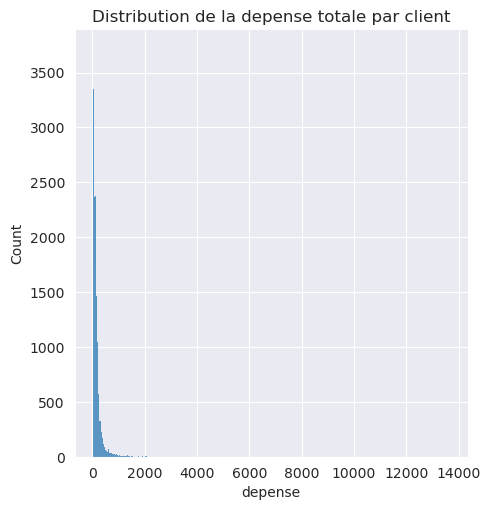

In [142]:
sns.displot(synthese_df['depense'])
plt.title("Distribution de la depense totale par client")
plt.show()

In [143]:
synthese_df['depense'].describe()

count    93358.000000
mean       165.198539
std        226.313378
min          9.590000
25%         63.060000
50%        107.780000
75%        182.557500
max      13664.080000
Name: depense, dtype: float64

Si la depense moyenne, par client, est autour de 165 Real Dollars, on constate quelques valeurs extremes comme une commande a plus de 13k !

In [144]:
depense_moyenne_globale = synthese_df['depense'].mean()

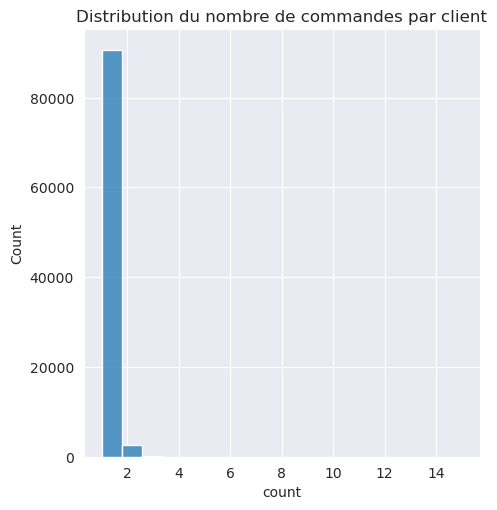

In [146]:
sns.displot(synthese_df['count'])
plt.title("Distribution du nombre de commandes par client")
plt.show()

La grande majorité des clients n'a fait qu'une commande. C'est assez caracteristique du business model d'une telle plateforme : les produits sont postes sur differentes marketplace. La clientelle associee n'est donc, a priori, pas sur ces plateformes pour etre fidele a un revendeur specifique.

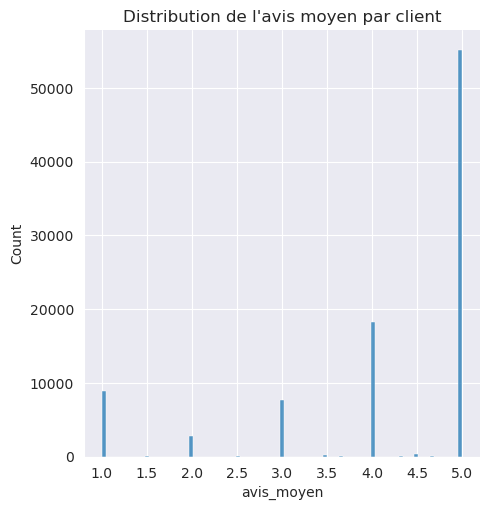

In [147]:
sns.displot(synthese_df['avis_moyen'])
plt.title("Distribution de l'avis moyen par client")
plt.show()

Même si l'avis moyen est très bon.

Le business même n'est pas très propice à la fidelisation puisque le but est de pousser un même produit sur différentes market place, qui disposent d'une audience captive distincte.

# 4. Segmentation RFM

N.B : La RFM est deja une forme de segmentation. Cependant cette segmentation étant assez simple, elle aide ici a mieux explorer le dataset.

In [149]:
DATEREF = max(synthese_df['datedernierachat'])

In [150]:
# On convertit a la difference en jour 
synthese_df['recence'] = (DATEREF - synthese_df['datedernierachat']).apply(lambda x: x.days)
synthese_df.head(4)

,client,depense,count,datedernierachat,avis_moyen,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,2018-05-10 10:56:27,5.0,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,2018-05-07 11:11:27,4.0,114
2,0000f46a3911fa3c0805444483337064,86.22,1,2017-03-10 21:05:03,3.0,536
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,2017-10-12 20:29:41,4.0,320


In [151]:
synthese_df['segments_R'] = pd.qcut(synthese_df['recence'], 4)
synthese_df['note_R'] = pd.qcut(synthese_df['recence'], 4, labels=False)
synthese_df['segments_R'].value_counts()

segments_R
(113.0, 218.0]     23451
(-0.001, 113.0]    23396
(345.0, 713.0]     23311
(218.0, 345.0]     23200
Name: count, dtype: int64

In [152]:
synthese_df['note_R'].value_counts()

note_R
1    23451
0    23396
3    23311
2    23200
Name: count, dtype: int64

In [153]:
synthese_df.loc[synthese_df['note_R']==0, 'note_R'] = 4
synthese_df.loc[synthese_df['note_R']==3, 'note_R'] = 0
synthese_df.loc[synthese_df['note_R']==4, 'note_R'] = 3
synthese_df.loc[synthese_df['note_R']==2, 'note_R'] = 4
synthese_df.loc[synthese_df['note_R']==1, 'note_R'] = 2
synthese_df.loc[synthese_df['note_R']==4, 'note_R'] = 1
synthese_df['note_R'].value_counts()

note_R
2    23451
3    23396
0    23311
1    23200
Name: count, dtype: int64

In [156]:
synthese_df['note_F'] = 1
synthese_df.loc[synthese_df['count'] > 1, 'note_F'] = 2
synthese_df['note_F'].value_counts()

note_F
1    90557
2     2801
Name: count, dtype: int64

In [157]:
synthese_df['segments_M'] = pd.qcut(synthese_df['depense'], 4)
synthese_df['note_M'] = pd.qcut(synthese_df['depense'], 4, labels=False)
synthese_df['segments_M'].value_counts()

segments_M
(9.589, 63.06]         23341
(182.558, 13664.08]    23340
(63.06, 107.78]        23339
(107.78, 182.558]      23338
Name: count, dtype: int64

In [158]:
synthese_df.head(2)

,client,depense,count,datedernierachat,avis_moyen,recence,segments_R,note_R,note_F,segments_M,note_M
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,2018-05-10 10:56:27,5.0,111,"(-0.001, 113.0]",3,1,"(107.78, 182.558]",2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,2018-05-07 11:11:27,4.0,114,"(113.0, 218.0]",2,1,"(9.589, 63.06]",0


In [159]:
synthese_df['note_totale'] = synthese_df['note_R'] + synthese_df['note_F'] + synthese_df['note_M']

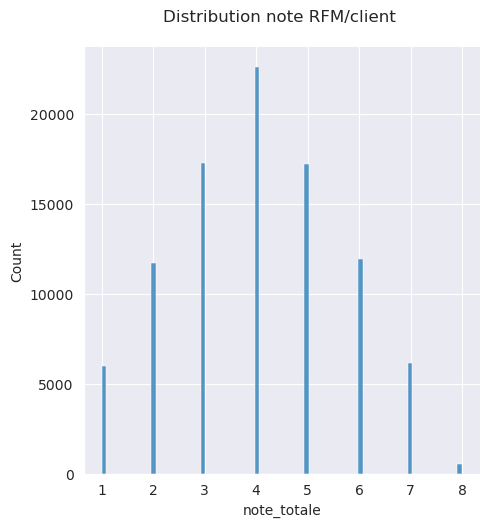

In [160]:
sns.displot(data = synthese_df, x='note_totale')
plt.title("Distribution note RFM/client \n")
plt.show()

In [161]:
synthese_df['note_totale'].value_counts()

note_totale
4    22586
3    17251
5    17222
6    11947
2    11721
7     6147
1     5964
8      520
Name: count, dtype: int64

On va associer a chaque note une categorie plus litterale de maniere a faciliter la comprehension de nos profils clients.

In [162]:
synthese_df.loc[synthese_df['note_totale'] == 8 , 'RFM_cat'] = "MVC - Ambassadeurs.rices"
synthese_df.loc[synthese_df['note_totale'] == 7 , 'RFM_cat'] = "Champions.nes"
synthese_df.loc[synthese_df['note_totale'] == 6 , 'RFM_cat'] = "Loyaux"
synthese_df.loc[synthese_df['note_totale'] == 5 , 'RFM_cat'] = "Requiers de l'attention"
synthese_df.loc[synthese_df['note_totale'] == 4 , 'RFM_cat'] = "Potentiels"
synthese_df.loc[synthese_df['note_totale'] == 3 , 'RFM_cat'] = "Prommetteurs"
synthese_df.loc[synthese_df['note_totale'] == 2 , 'RFM_cat'] = "Eventuels"
synthese_df.loc[synthese_df['note_totale'] == 1 , 'RFM_cat'] = "En sommeil"
synthese_df['RFM_cat'].value_counts()

RFM_cat
Potentiels                  22586
Prommetteurs                17251
Requiers de l'attention     17222
Loyaux                      11947
Eventuels                   11721
Champions.nes                6147
En sommeil                   5964
MVC - Ambassadeurs.rices      520
Name: count, dtype: int64

In [164]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = synthese_df.groupby('RFM_cat').agg({
    'recence': 'mean',
    'count': 'mean',
    'depense': ['mean', 'count']
}).round(1)# Print the aggregated dataset
print(rfm_level_agg)

                         recence count depense       
                            mean  mean    mean  count
RFM_cat                                              
Champions.nes               66.4   1.1   392.2   6147
En sommeil                 453.4   1.0    43.7   5964
Eventuels                  363.2   1.0    64.1  11721
Loyaux                     115.7   1.1   258.5  11947
MVC - Ambassadeurs.rices    58.3   2.2   432.0    520
Potentiels                 234.9   1.0   163.0  22586
Prommetteurs               294.9   1.0    87.5  17251
Requiers de l'attention    170.9   1.0   202.9  17222


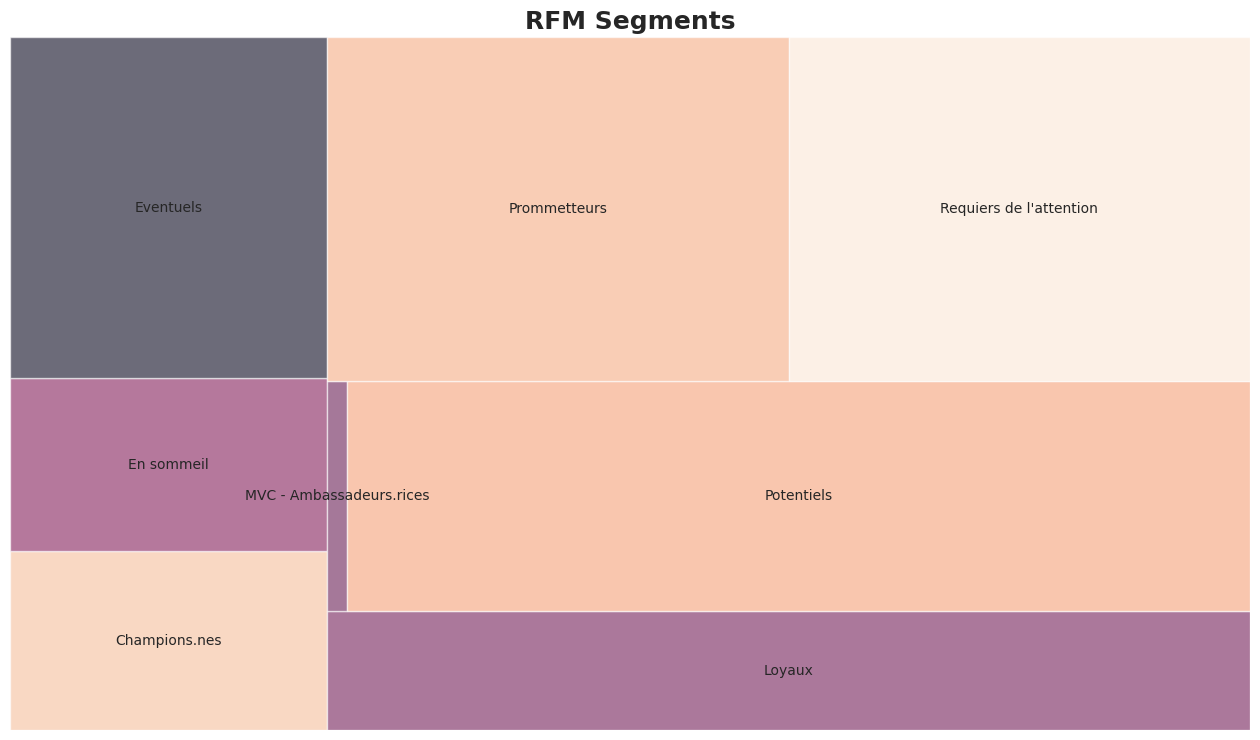

In [165]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=[
                     "Champions.nes",
                     "En sommeil",
                     "Eventuels",
                     "Loyaux",
                     "MVC - Ambassadeurs.rices",
                     "Potentiels",
                     "Prommetteurs",
                     "Requiers de l'attention"
              ], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

Les catégories intermédiaires de la RFM ne sont pas les plus faciles à interpréter, mais les extrêmités, elles, le sont. On voit ainsi notre petite part d'ambassadeurs et d'ambassadrices de marques, ainsi que notre part de clients "en hibernation".

### Representation graphique des distributions

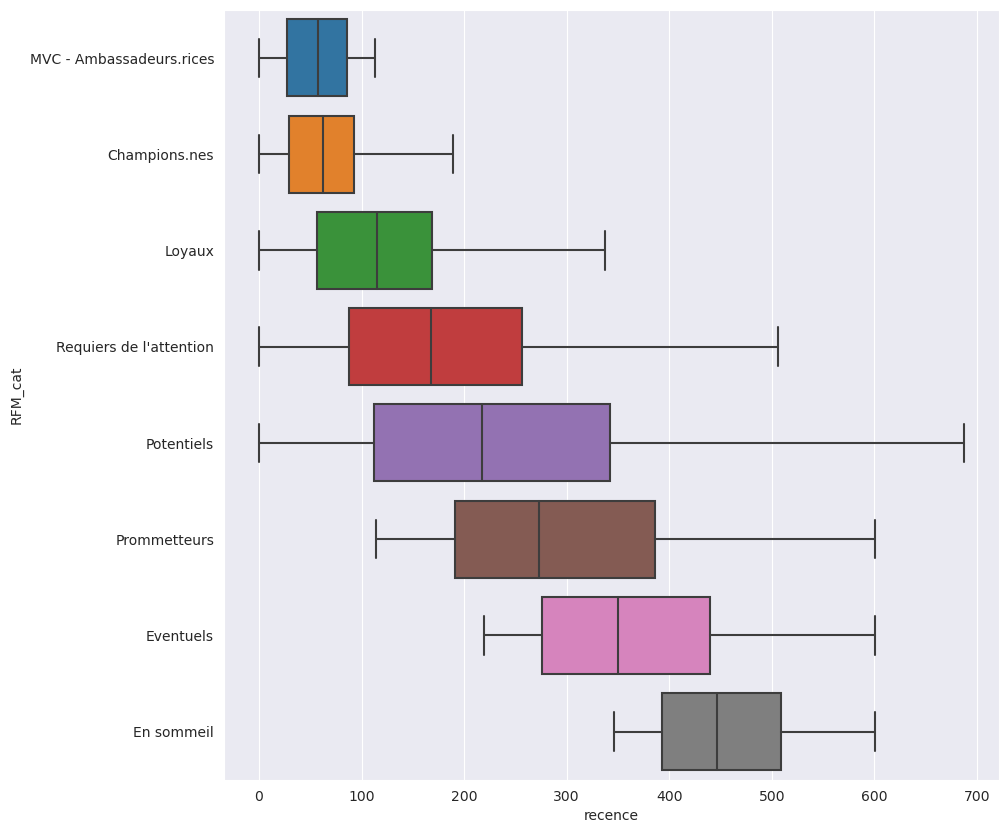

In [166]:
cv810.boxplot_numfeature(df=synthese_df, feature = 'recence', label = 'RFM_cat', viz_outliers=False)

L'outlier qui a depense 14k "Requiert de l'attention" xD.

Cependant, pour cette representation, on ne va pas afficher les outliers, car ils nuisent a la visualisation en applatissant les boites a moustaches.

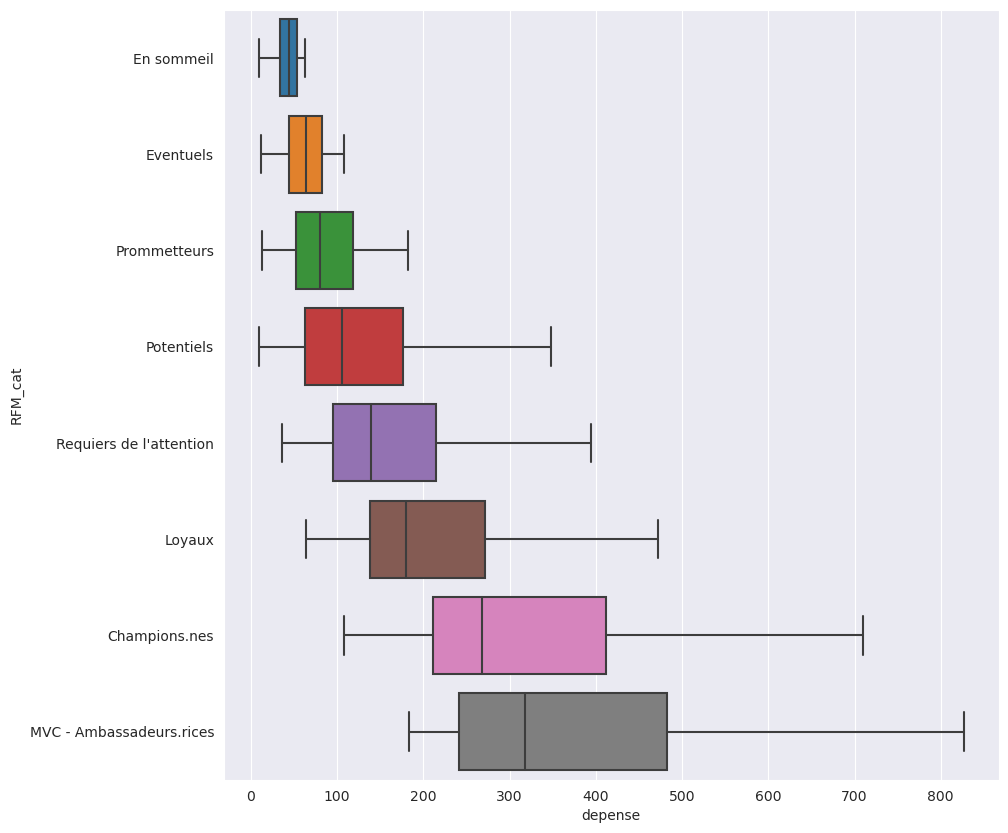

In [167]:
cv810.boxplot_numfeature(df=synthese_df, feature = 'depense', label = 'RFM_cat', viz_outliers=False)

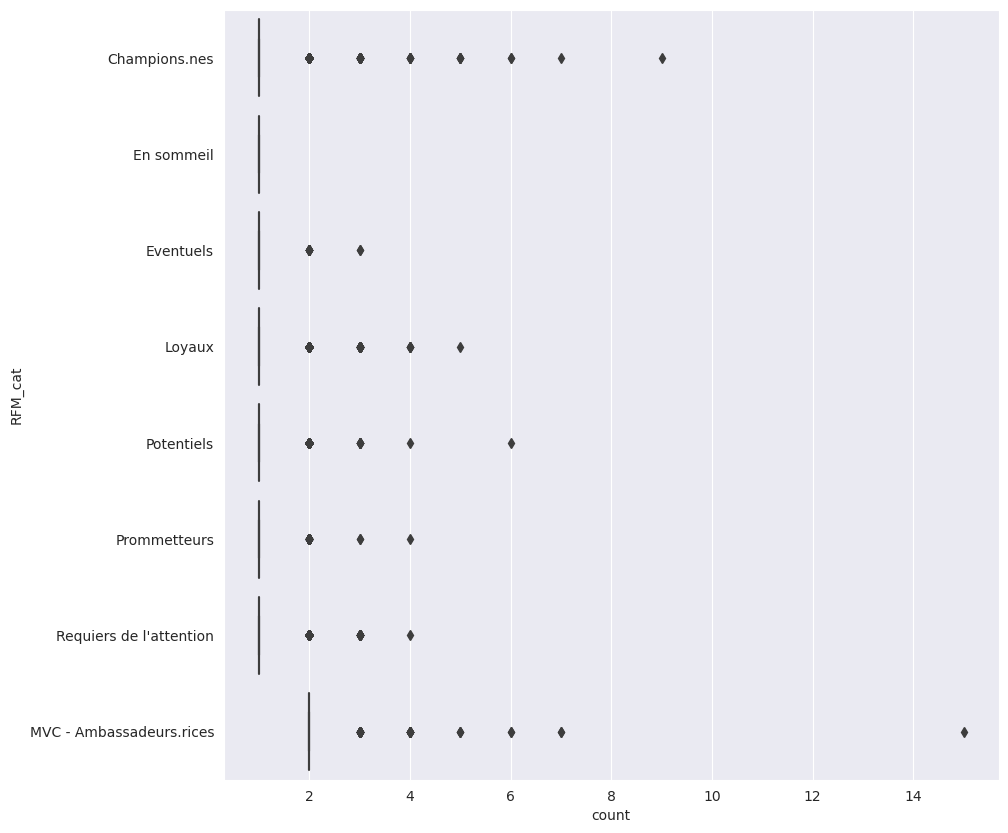

In [169]:
cv810.boxplot_numfeature(df=synthese_df, feature = 'count', label = 'RFM_cat', viz_outliers=True)

# 5. Focus Clients réguliers.

In [175]:
def commandes_clients_reguliers(df_ini) :
    # Frequence d'achat (ou plutot nombre de commandes)
    nb_commandes = df_ini['customer_unique_id'].value_counts().reset_index()
    nb_commandes = nb_commandes[nb_commandes['count'] > 1]
    res_df = df_ini[df_ini['customer_unique_id'].isin(nb_commandes['customer_unique_id'])]
    res_df = res_df.sort_values(by=['order_purchase_timestamp'], ascending = True)
    return res_df

In [176]:
commandes_yencli_reg = commandes_clients_reguliers(df)
commandes_yencli_reg.head(2)

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,payment_value,review_score
93285,3b697a20d9e427646d92567910af6d57,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,SP,45.46,4.0
86163,60762802b48bb6d256d55b013d115013,2016-10-04 14:49:13,0b3dc7efaafb0cf78a4796d42fa8d74c,RJ,263.93,5.0


In [177]:
print("Nombre de clients reguliers", commandes_yencli_reg['customer_unique_id'].nunique())
print("Nombre de clients totaux", df['customer_unique_id'].nunique())
print(f"Soit {np.round((commandes_yencli_reg['customer_unique_id'].nunique()/df['customer_unique_id'].nunique())*100, 1)} %")

Nombre de clients reguliers 2801
Nombre de clients totaux 93358
Soit 3.0 %


In [178]:
commandes_yencli_reg.shape

(5921, 6)

In [179]:
panier_moyen_client_regulier = commandes_yencli_reg['payment_value'].mean()
print("Panier moyen client regulier : ", panier_moyen_client_regulier)
print(f"Soit {np.round((panier_moyen_client_regulier-panier_moyen_global)/panier_moyen_global*100, 2)}% Par rapport au panier global.")

Panier moyen client regulier :  145.981626414457
Soit -8.68% Par rapport au panier global.


In [180]:
commandes_yencli_reg['customer_unique_id'].value_counts().describe()

count    2801.000000
mean        2.113888
std         0.503796
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        15.000000
Name: count, dtype: float64

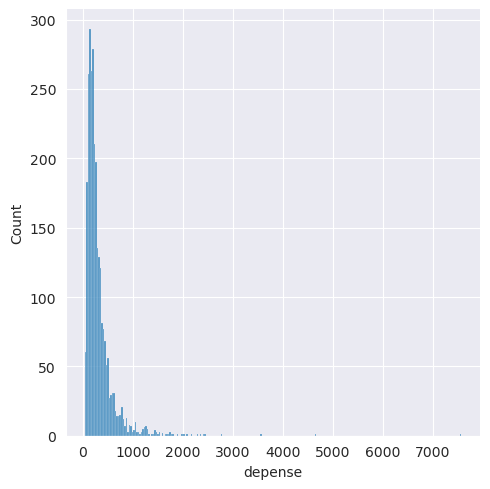

In [181]:
synthese_df_cr = creer_tableau_synthese(df_ini=commandes_yencli_reg)
sns.displot(synthese_df_cr['depense'])
plt.show()

In [183]:
synthese_df_cr['depense'].describe()

count    2801.000000
mean      308.588793
std       316.979193
min        35.940000
25%       147.130000
50%       225.550000
75%       361.020000
max      7571.630000
Name: depense, dtype: float64

In [184]:
depense_moyenne_client_regulier = synthese_df_cr['depense'].mean()
print(f"La depense moyenne globale a evoluee de {np.round(((depense_moyenne_client_regulier-depense_moyenne_globale)/depense_moyenne_globale)*100, 2)}%")

La depense moyenne globale a evoluee de 86.8%


On voit que le panier moyen du client régulier est légèrement moins élevé que le panier moyen du client lambda (régulier ou non).

Cependant, la dépense totale moyenne des clients réguliers est deux fois plus élevée que celle globale.

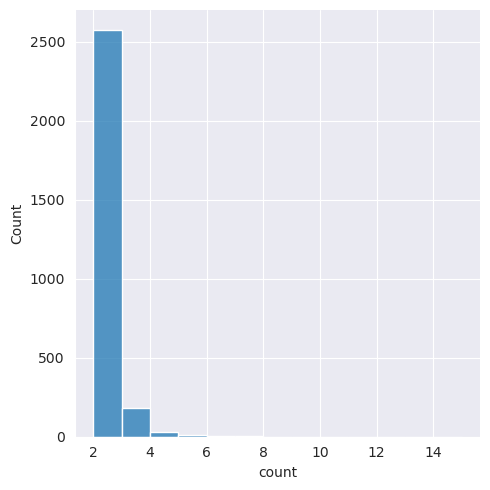

In [186]:
sns.displot(synthese_df_cr['count'])
plt.show()

In [188]:
date_premier_achat_client = commandes_yencli_reg.groupby(by='customer_unique_id')['order_purchase_timestamp'].min().reset_index()
date_premier_achat_client.head(3)

,customer_unique_id,order_purchase_timestamp
0,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:03
1,00a39521eb40f7012db50455bf083460,2018-05-23 20:14:21
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:22


In [189]:
commandes_yencli_reg[commandes_yencli_reg['customer_unique_id'] == '00cc12a6d8b578b8ebd21ea4e2ae8b27']

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,payment_value,review_score
60381,64307ceb91666760cf3ff463618302fd,2017-03-21 19:25:22,00cc12a6d8b578b8ebd21ea4e2ae8b27,SP,44.42,3.0
84191,d61b915b69851aec8a8865f36cfd793e,2017-03-21 19:25:23,00cc12a6d8b578b8ebd21ea4e2ae8b27,SP,81.78,3.0


In [190]:
# ATTENTION : Je n'ai pas que les deuxieme achats ici
tst = commandes_yencli_reg.groupby(by='customer_unique_id')['order_purchase_timestamp'].diff().reset_index()
tst = tst[~tst['order_purchase_timestamp'].isnull()]

In [191]:
tst.describe()

,index,order_purchase_timestamp
count,3120.000000,3120
mean,49465.318269,79 days 03:36:23.161538462
std,28813.467396,107 days 07:06:44.281058198
min,0.000000,0 days 00:00:00
25%,24121.000000,0 days 00:09:32
50%,49919.500000,29 days 10:55:57.500000
75%,74104.500000,121 days 11:15:00.250000
max,99427.000000,608 days 23:29:38


In [192]:
commandes_yencli_reg[commandes_yencli_reg['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,payment_value,review_score
33657,a61d617fbe5bd006e40d3a0988fc844b,2017-07-27 14:13:03,004288347e5e88a27ded2bb23747066c,RJ,251.09,5.0
40042,08204559bebd39e09ee52dcb56d8faa2,2018-01-14 07:36:54,004288347e5e88a27ded2bb23747066c,RJ,103.28,5.0


On va ensuite calculer le delta temporel entre la première et la dernière commande.

In [193]:
premier_ordres = commandes_yencli_reg.loc[commandes_yencli_reg.groupby('customer_unique_id')['order_purchase_timestamp'].idxmin()]

In [195]:
premier_ordres.head(3)

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,payment_value,review_score
33657,a61d617fbe5bd006e40d3a0988fc844b,2017-07-27 14:13:03,004288347e5e88a27ded2bb23747066c,RJ,251.09,5.0
34099,7d32c87acba91ed87ebd98310fe1c54d,2018-05-23 20:14:21,00a39521eb40f7012db50455bf083460,Autres,96.47,4.0
60381,64307ceb91666760cf3ff463618302fd,2017-03-21 19:25:22,00cc12a6d8b578b8ebd21ea4e2ae8b27,SP,44.42,3.0


- enelever les premiers ordres
- prendre le min : les seconds ordres

In [196]:
sans_po = commandes_yencli_reg[~commandes_yencli_reg['order_id'].isin(premier_ordres['order_id'].tolist())]
sans_po.shape

(3120, 6)

In [197]:
seconds_ordres = sans_po.loc[sans_po.groupby('customer_unique_id')['order_purchase_timestamp'].idxmin()]
seconds_ordres.shape

(2801, 6)

In [198]:
cr_ordre_sdf = premier_ordres[['customer_unique_id', 'order_purchase_timestamp']].merge(seconds_ordres[['customer_unique_id', 'order_purchase_timestamp']], on='customer_unique_id', how='left')
cr_ordre_sdf.head(2)

,customer_unique_id,order_purchase_timestamp_x,order_purchase_timestamp_y
0,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:03,2018-01-14 07:36:54
1,00a39521eb40f7012db50455bf083460,2018-05-23 20:14:21,2018-06-03 10:12:57


In [199]:
cr_ordre_sdf['delta'] = cr_ordre_sdf['order_purchase_timestamp_y'] - cr_ordre_sdf['order_purchase_timestamp_x']
cr_ordre_sdf['days'] = cr_ordre_sdf['delta'].dt.days
cr_ordre_sdf.head(3)

,customer_unique_id,order_purchase_timestamp_x,order_purchase_timestamp_y,delta,days
0,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:03,2018-01-14 07:36:54,170 days 17:23:51,170
1,00a39521eb40f7012db50455bf083460,2018-05-23 20:14:21,2018-06-03 10:12:57,10 days 13:58:36,10
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:22,2017-03-21 19:25:23,0 days 00:00:01,0


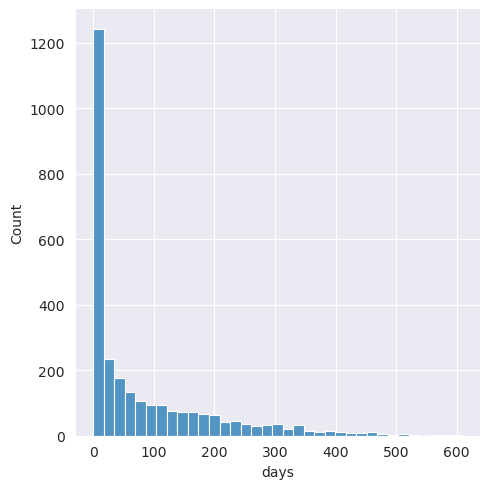

In [200]:
sns.displot(cr_ordre_sdf['days'])

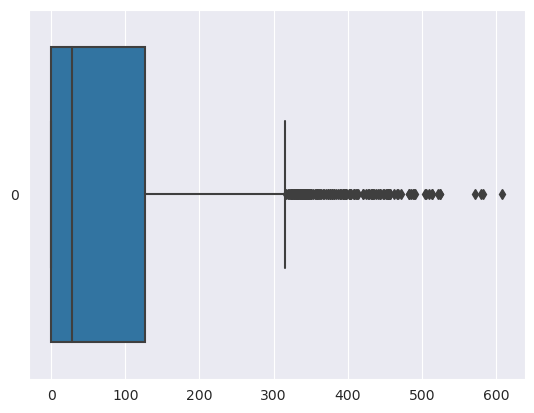

In [201]:
sns.boxplot(cr_ordre_sdf['days'], orient='h')
plt.show()

In [202]:
cr_ordre_sdf['days'].describe()

count    2801.000000
mean       80.844698
std       109.899443
min         0.000000
25%         0.000000
50%        28.000000
75%       126.000000
max       608.000000
Name: days, dtype: float64

50% des clients réguliers ont procédé à leur deuxième achat, dans les 30 jours suivant leur premier achat. 75% dans les 126 jours.

In [203]:
np.round(commandes_yencli_reg.shape[0]/df.shape[0]*100, 2)

6.14

# 6. CA glissant sur l'annee.

In [204]:
df_tempo = df.set_index('order_purchase_timestamp')
df_tempo = df_tempo.sort_values(by='order_purchase_timestamp', ascending=True)
df_tempo.head(2)

,order_id,customer_unique_id,customer_state,payment_value,review_score
order_purchase_timestamp,,,,,
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,SP,143.46,1.0
2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57,32ea3bdedab835c3aa6cb68ce66565ef,SP,45.46,4.0


In [205]:
print("Debut du dataset : ", df_tempo.index.min())
print("Fin du dataset : ", df_tempo.index.max())

Debut du dataset :  2016-09-15 12:16:38
Fin du dataset :  2018-08-29 15:00:37


Seule l'annee 2017 est une annee complete. 2016 demarre en septembre et 2018 s'arrete en aout.

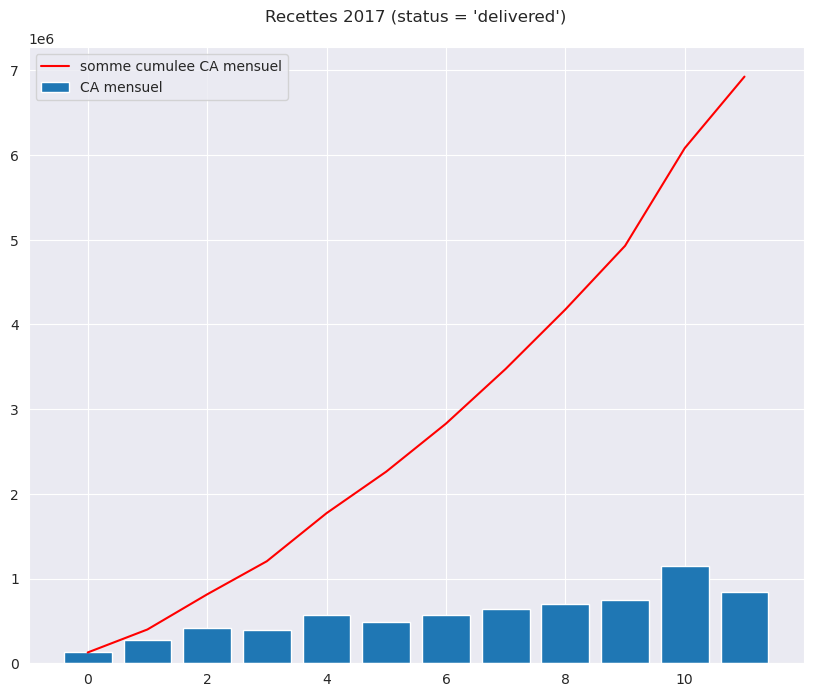

In [206]:
# Evolution du bitcoin en 2019 en faisant la moyenne par mois
df_recette_mensuelle = df_tempo.loc['2017', 'payment_value'].resample('M').sum().reset_index()
df_recette_mensuelle['cumsum'] = df_recette_mensuelle['payment_value'].cumsum()
plt.figure(figsize=(10, 8))
plt.bar(x=df_recette_mensuelle.index,height = df_recette_mensuelle['payment_value'], label="CA mensuel")
plt.plot(df_recette_mensuelle['cumsum'], c='r', label = "somme cumulee CA mensuel")
plt.title("Recettes 2017 (status = 'delivered')\n")
plt.legend()
plt.show()

In [207]:
print("CA annuel 2017 : ", np.round(df_recette_mensuelle.iloc[-1,-1], 0))

CA annuel 2017 :  6922900.0


# 7. ACP, clients

Cette ACP a ete realisee apres la segmentation K-Means, simplement pour s'offrir une visualisation sur les differents plans factoriels et toujours mieux comprendre notre base client.

In [208]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

On repart d'un dataframe qu'on a cree suite au modelisation, mais qui contient les donnees synthetiques relatives aux differents clients

In [209]:
df = pd.read_csv('./model_results/kmeans_20230223.csv')
df.head(2)

,client,depense,nbcommandes,recence,avis_moyen,nb_items_moyen,reducs,montant_reducs,categorie_produit_preferee,big_k4_label,outliers_dfbig_k4_c1,small_k6_is_outlier,small_k6_label,small_k8_label,small_k8_is_outlier
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,111,5.0,1.0,0.0,0.0,bed_bath_table,0,0,0,1,2,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,114,4.0,1.0,0.0,0.0,health_beauty,0,0,0,1,2,0


In [210]:
acp_df = df.drop(columns=['client', 'categorie_produit_preferee', 'big_k4_label', 'outliers_dfbig_k4_c1', 'small_k6_is_outlier', 'small_k6_label', 'small_k8_label', 'small_k8_is_outlier'])

In [211]:
X = acp_df.values
print(f"Type X : {type(X)}")
features = acp_df.columns
print(f"feature : {features}")
names = df.loc[:, 'client']

Type X : <class 'numpy.ndarray'>
feature : Index(['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen',
       'reducs', 'montant_reducs'],
      dtype='object')


In [212]:
X_scaled = StandardScaler().fit_transform(X)

In [213]:
n_components = len(features)
acp = PCA(n_components=n_components)
acp.fit(X_scaled)

PCA(n_components=7)

In [214]:
acp.explained_variance_ratio_

array([0.21626859, 0.18120335, 0.15003667, 0.14130023, 0.12951203,
       0.1111873 , 0.07049183])

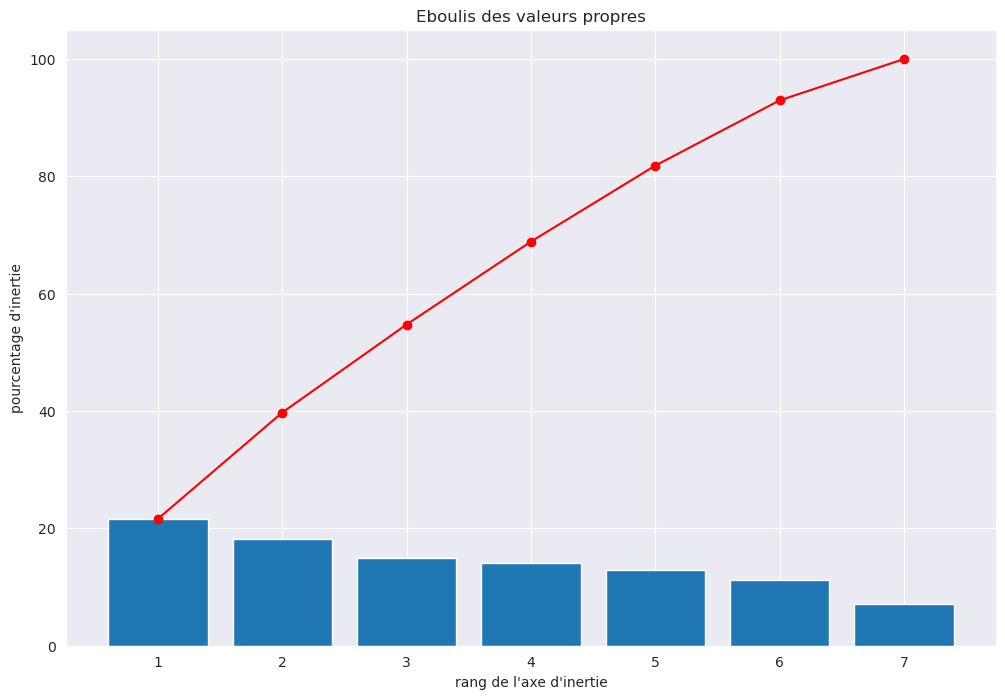

In [215]:
scree = (acp.explained_variance_ratio_*100).round(2)
scree_cum = (acp.explained_variance_ratio_*100).cumsum()
x_list = range(1, n_components+1)
plt.figure(figsize = (12, 8))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c='r', marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

S'il y a un coude, il serait a 6. Ce qui réduirait de 1 notre dimensionnalité. Pas super utile.

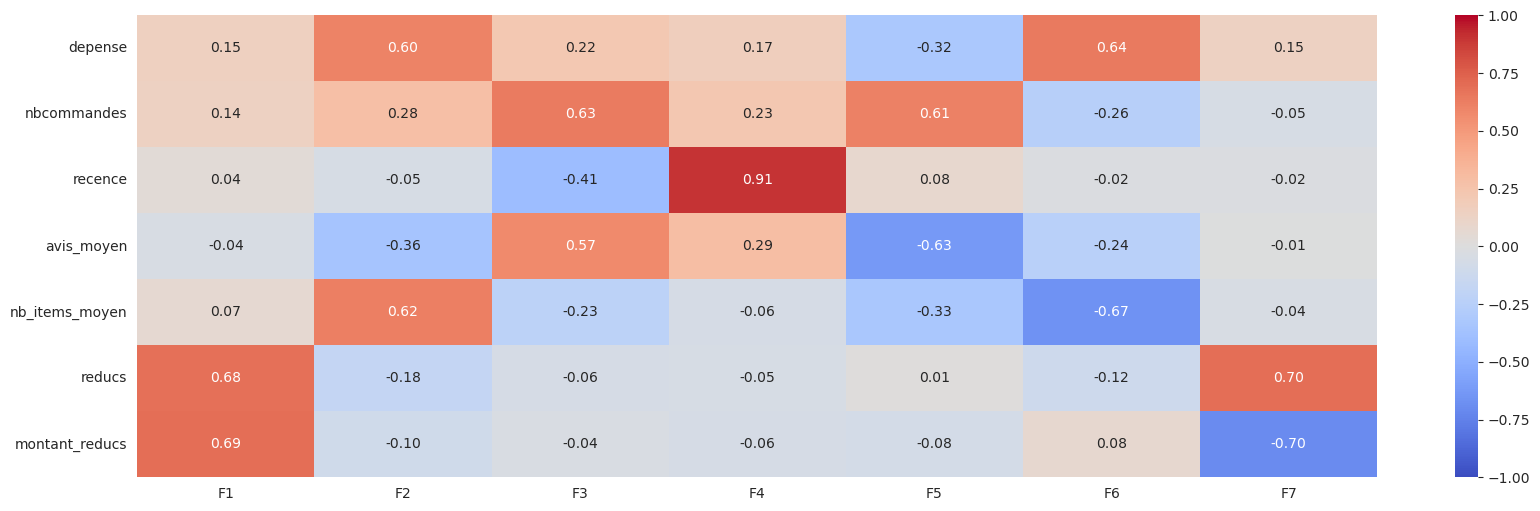

In [216]:
pcs = acp.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

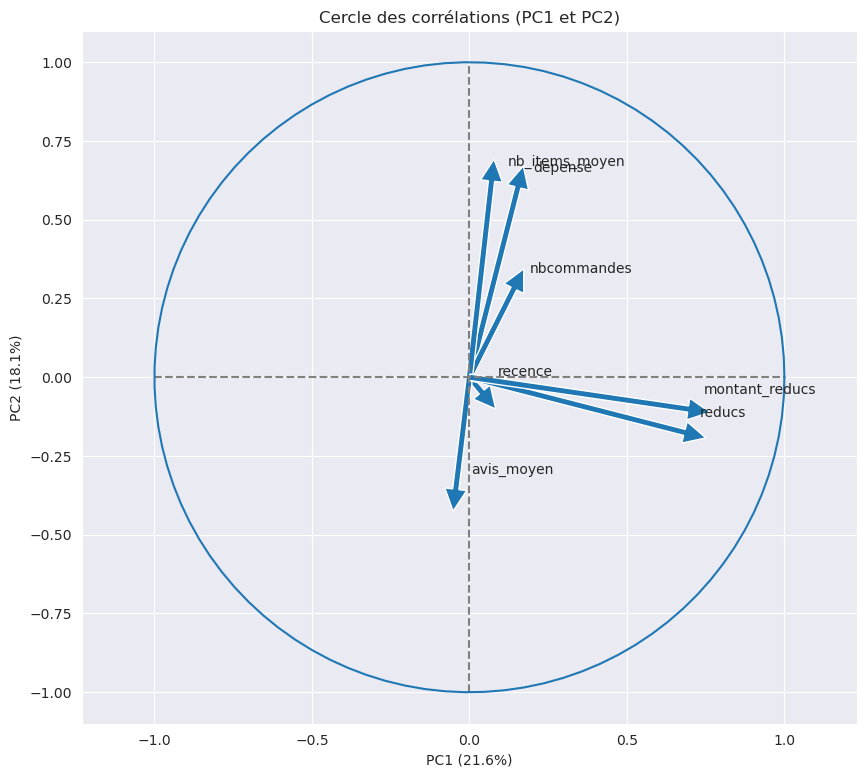

In [217]:
acp810.correlation_graph(acp, (0, 1), features)

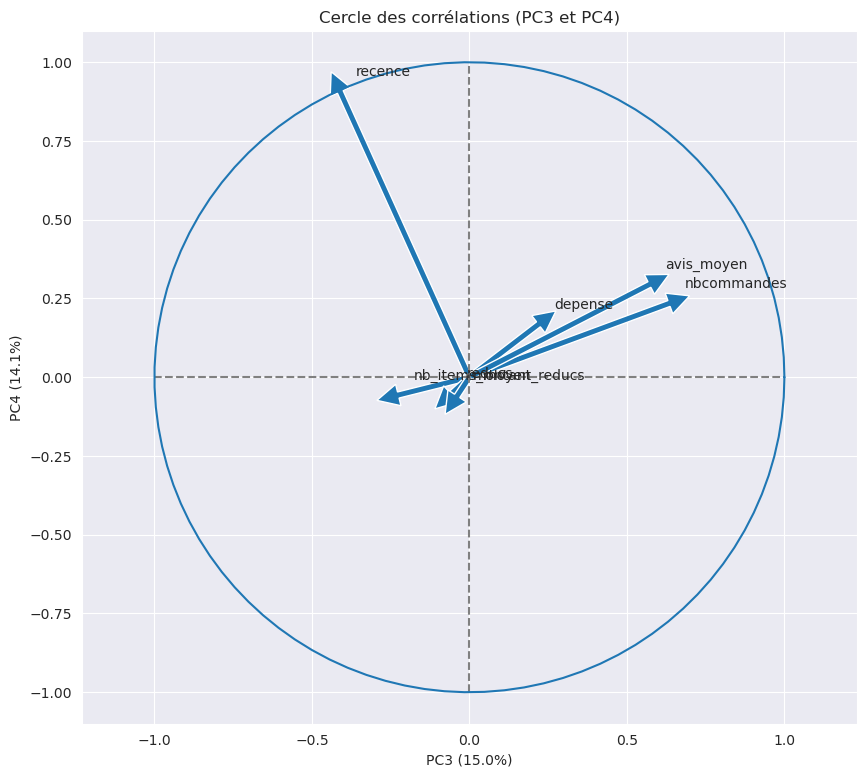

In [218]:
acp810.correlation_graph(acp, (2, 3), features)

In [219]:
X_proj = acp.transform(X_scaled)
df_proj = pd.DataFrame(X_proj, columns=[f"PC{i}" for i in x_list], index=names)
print(f"Shape : {df_proj.shape}")
df_proj.head(3)

Shape : (93358, 7)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
client,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.297255,-0.430711,0.663060,-0.579234,-0.452942,0.011481,0.009504
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.340592,-0.458845,0.096833,-0.876796,0.206015,-0.124359,-0.060300
0000f46a3911fa3c0805444483337064,-0.158725,-0.153311,-1.426989,1.442339,0.842430,0.186255,-0.071751


In [220]:
df_proj = df_proj.merge(df[['client', 'small_k6_label']], on='client', how='left')
df_proj.head(2)

,client,PC1,PC2,PC3,PC4,PC5,PC6,PC7,small_k6_label
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.297255,-0.430711,0.663060,-0.579234,-0.452942,0.011481,0.009504,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.340592,-0.458845,0.096833,-0.876796,0.206015,-0.124359,-0.060300,1


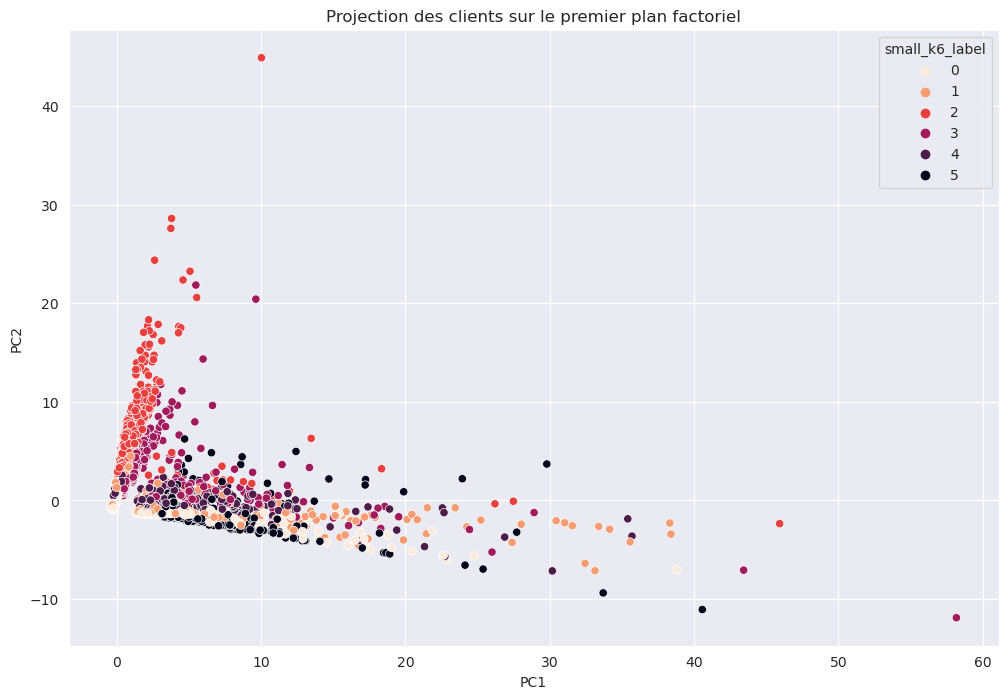

In [221]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_proj, x='PC1', y='PC2', hue='small_k6_label', palette="rocket_r")
plt.title("Projection des clients sur le premier plan factoriel")
plt.show()

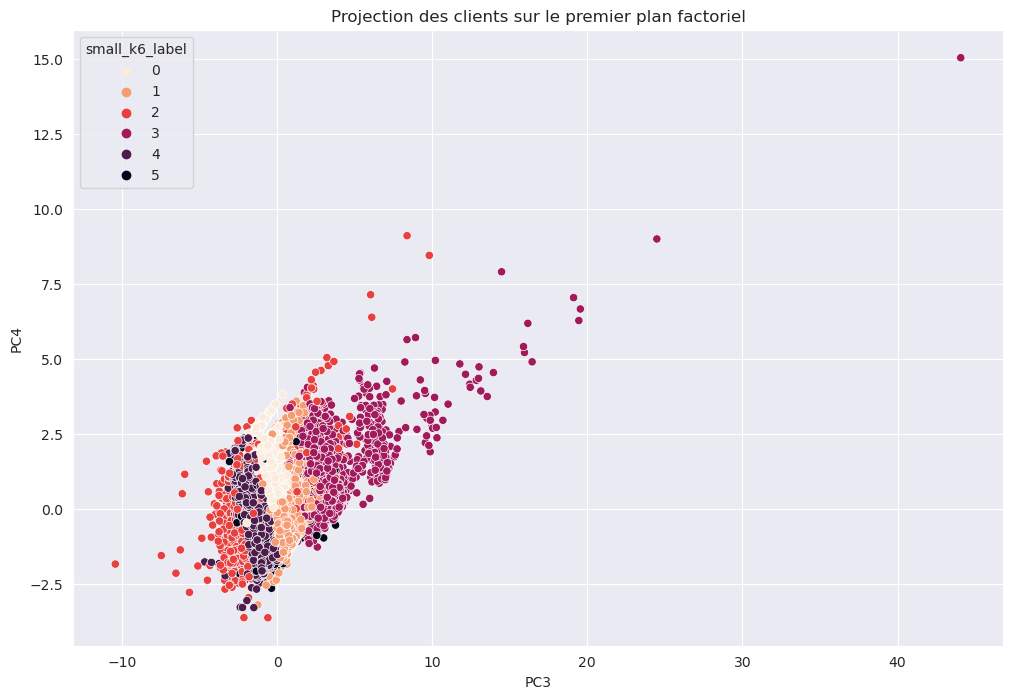

In [222]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_proj, x='PC3', y='PC4', hue='small_k6_label', palette="rocket_r")
plt.title("Projection des clients sur le premier plan factoriel")
plt.show()

__Perspectives d'amelioration :__
- L'ACP réalisée est appliquée au dataset incluant les __features__ liées aux __vouchers__. Or, ces features ne sont pas utilisées pour toutes nos clusterisation. Il pourrait être intéressant de refaire une ACP sans ces features additionnelles.

# Analyse des distributions

Une simple visualisation des distributions pour nos deux types de dataframe

1. Le dataframe des commandes
2. Le dataframe des clients

In [223]:
df = pd.read_csv('./data_travail/df_merged.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],yearfirst=True)
df.head(2)

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,nb_items,cat_produit,reducs,montant_reducs,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,housewares,2.0,20.59,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,Autres,1.0,perfumery,0.0,0.00,141.46,4.0


In [224]:
numcols = ['nb_items', 'reducs', 'montant_reducs', 'payment_value', 'review_score']

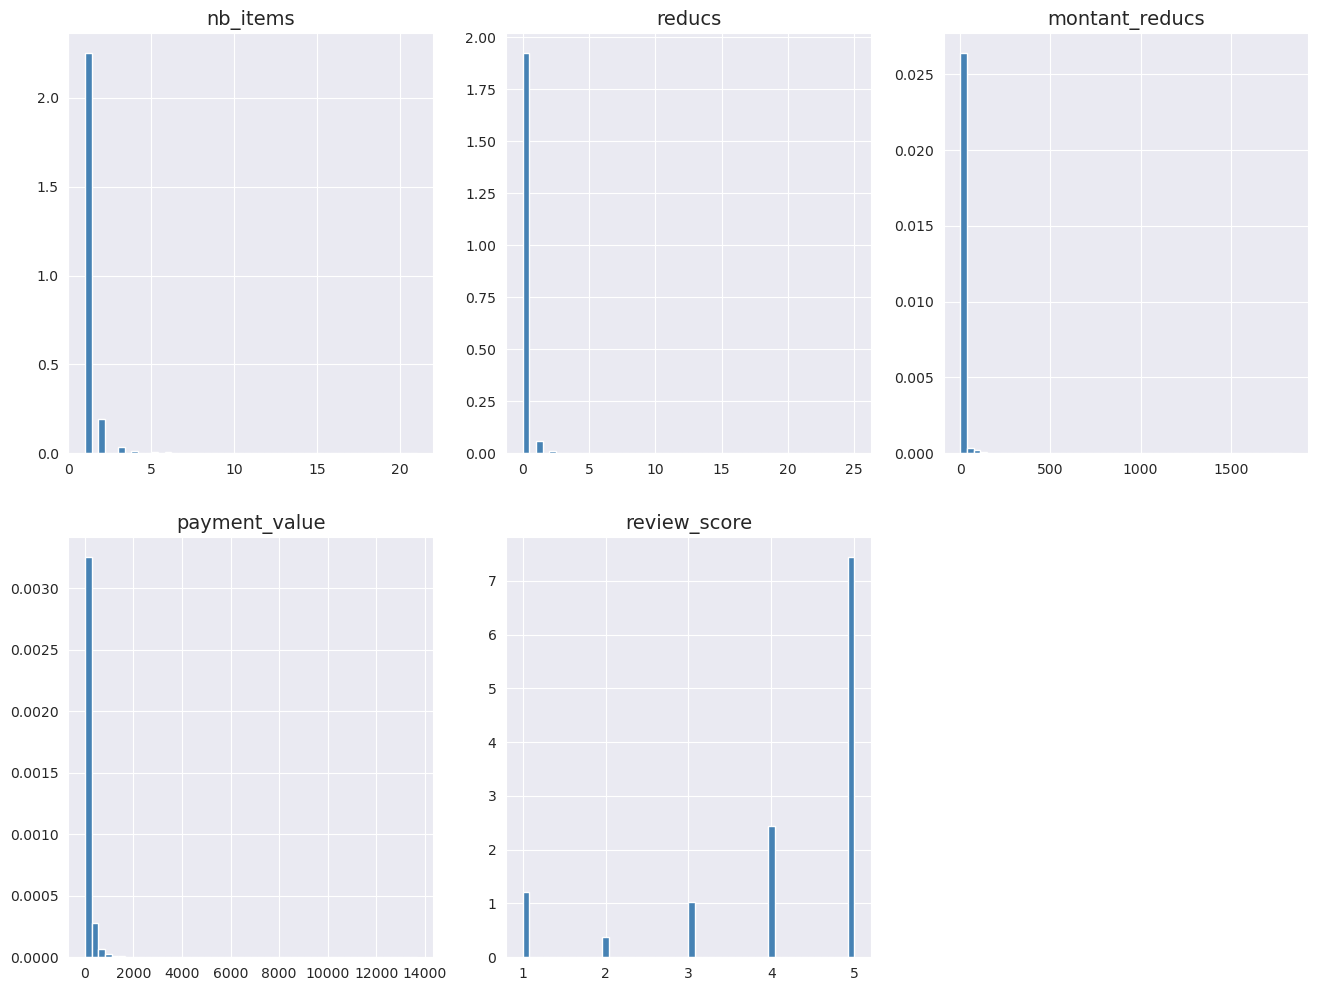

In [225]:
# On va tracer un histogramme pour chacune de nos 11 variables de maniere a bien les observer
fig = plt.figure(figsize=(16, 12))
cnt = 0
for ncol in numcols :
    cnt+=1
    ax = fig.add_subplot(2, 3, cnt)
    # Normed = Normalisee (est devenu 'density=True')
    # edgecolor = contour des barres du barchart
    h = ax.hist(df[ncol], bins=50, color='steelblue', density= True, edgecolor = None) 
    ax.set_title(ncol, fontsize = 14)
plt.show()